In [64]:
import cv2
import cv2.aruco as aruco
from glob import glob
import pandas as pd
from os.path import basename
from scipy import stats
import numpy as np

In [65]:
F = 3

In [66]:
# Define the parameters for the Charuco board
num_squares_x = 5
num_squares_y = 7
square_length = 100
marker_length = 80

# Create the Charuco board
board = aruco.CharucoBoard(
    size=(num_squares_x, num_squares_y),
    squareLength=square_length,
    markerLength=marker_length,
    dictionary=aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
)

In [67]:
images = pd.DataFrame(glob(
    f'../../../bilderserien/Focustest/F{F}/*.jpg'), columns=['path'])
images.reset_index(inplace=True)
images.rename(inplace=True, columns={"index": "img_id"})
images.set_index("img_id", inplace=True)
images["focus"] = [float(basename(i)[1:4]) for i in images["path"]]

In [68]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

# Create lists to store object points and image points
obj_points = []  # 3D points in real world space
img_points = []  # 2D points in image plane
img_point_ids = []  # IDs of the Charuco corners
img_paths = []  # Paths to the images

# Iterate over the images and detect Charuco corners
for img_id, img_path in images["path"].items():
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = aruco.detectMarkers(gray, board.getDictionary())
    if len(corners) > 0:
        # SUB PIXEL DETECTION
        for corner in corners:
            cv2.cornerSubPix(gray, corner,
                             winSize=(3, 3),
                             zeroZone=(-1, -1),
                             criteria=criteria)
        _, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            corners, ids, gray, board)
        if charuco_corners is not None and charuco_ids is not None and len(charuco_corners) >= 6:
            print(f"Detected Charuco corners in image {basename(img_path)}")
            obj_points.append(board.getChessboardCorners())
            img_points.append(charuco_corners)
            img_point_ids.append(charuco_ids)
            img_paths.append(img_path)

Detected Charuco corners in image 1707210153.jpg
Detected Charuco corners in image 1707210159.jpg
Detected Charuco corners in image 1707210165.jpg
Detected Charuco corners in image 1707210204.jpg
Detected Charuco corners in image 1707210211.jpg
Detected Charuco corners in image 1707215651.jpg
Detected Charuco corners in image 1707215667.jpg
Detected Charuco corners in image 1707215673.jpg
Detected Charuco corners in image 1707215680.jpg
Detected Charuco corners in image 1707215698.jpg
Detected Charuco corners in image f3.0_1.jpg
Detected Charuco corners in image f3.0_11.jpg
Detected Charuco corners in image f3.0_12.jpg
Detected Charuco corners in image f3.0_2.jpg
Detected Charuco corners in image f3.0_20.jpg
Detected Charuco corners in image f3.0_21.jpg
Detected Charuco corners in image f3.0_3 (1).jpg
Detected Charuco corners in image f3.0_4.jpg
Detected Charuco corners in image f3.0_6.jpg
Detected Charuco corners in image f3.0_7.jpg
Detected Charuco corners in image f3.0_8.jpg


In [76]:
c = 1/(1/0.00474+F)/0.0000014
cameraMatrixInit = np.array([[c,    0., 2304.],
                             [0., c, 1296.],
                             [0.,    0.,           1.]])
distCoeffsInit = np.zeros((5, 1))
cameraMatrixInit

array([[3.33824445e+03, 0.00000000e+00, 2.30400000e+03],
       [0.00000000e+00, 3.33824445e+03, 1.29600000e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [77]:
flags = (cv2.CALIB_USE_INTRINSIC_GUESS +
         cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
# flags = (cv2.CALIB_RATIONAL_MODEL)

# Calibrate the camera
(ret, camera_matrix, distortion_coefficients0,
 rotation_vectors, translation_vectors,
 stdDeviationsIntrinsics, stdDeviationsExtrinsics,
 perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
    charucoCorners=img_points,
    charucoIds=img_point_ids,
    board=board,
    imageSize=gray.shape[::-1],
    cameraMatrix=cameraMatrixInit,
    distCoeffs=distCoeffsInit,
    flags=flags,
    criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

In [78]:

# Print the camera matrix and distortion coefficients
print("Camera Matrix:")
print(camera_matrix)
print("Distortion Coefficients:")
print(distortion_coefficients0)
camera_matrix.dump(f"camera_matrixF{F}.npy")
distortion_coefficients0.dump(f"distortion_coefficientsF{F}.npy")

Camera Matrix:
[[3.44126962e+03 0.00000000e+00 2.22382966e+03]
 [0.00000000e+00 3.44126962e+03 1.37193861e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
[[ 2.35664913e+02]
 [-1.24789999e+03]
 [ 3.95887775e-03]
 [-8.98842754e-03]
 [ 2.25436600e+03]
 [ 2.41396285e+02]
 [-1.28863470e+03]
 [ 2.33408164e+03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


In [80]:
pd.DataFrame(list(zip(img_paths, perViewErrors)),
             columns=["path", "error"])

,path,error
0,../../../bilderserien/Focustest/F3/1707210153.jpg,[5.285328101168872]
1,../../../bilderserien/Focustest/F3/1707210159.jpg,[6.8260246167380965]
2,../../../bilderserien/Focustest/F3/1707210165.jpg,[5.6042766207739225]
3,../../../bilderserien/Focustest/F3/1707210204.jpg,[6.890007938355731]
4,../../../bilderserien/Focustest/F3/1707210211.jpg,[1.653145251932008]
5,../../../bilderserien/Focustest/F3/1707215651.jpg,[5.322041666694484]
6,../../../bilderserien/Focustest/F3/1707215667.jpg,[5.1666991843089205]
7,../../../bilderserien/Focustest/F3/1707215673.jpg,[7.1527778015269154]
8,../../../bilderserien/Focustest/F3/1707215680.jpg,[6.140427065163483]
9,../../../bilderserien/Focustest/F3/1707215698.jpg,[6.354619316926668]


In [82]:
stdDeviationsIntrinsics

array([[0.00000000e+00],
       [4.36496201e+01],
       [1.25145152e+01],
       [1.66286473e+01],
       [1.08858400e+02],
       [3.19417894e+02],
       [1.64884826e-03],
       [1.28945986e-03],
       [1.92307507e+02],
       [1.13577349e+02],
       [3.44889242e+02],
       [1.51529357e+02],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00]])

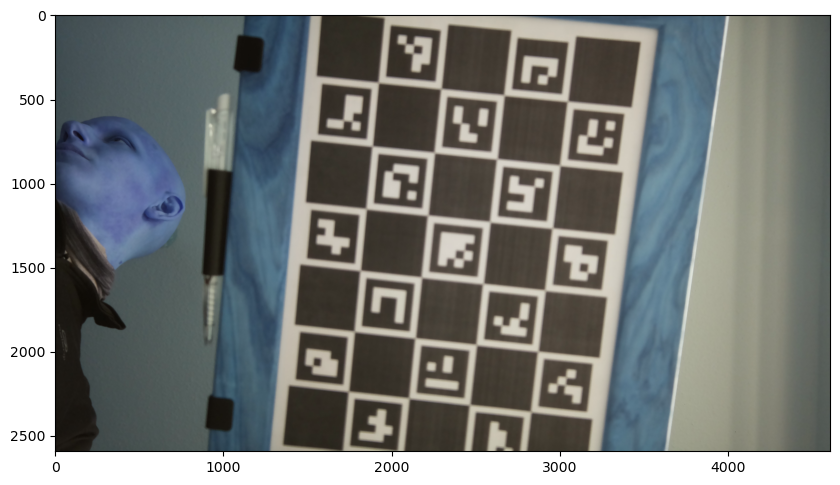

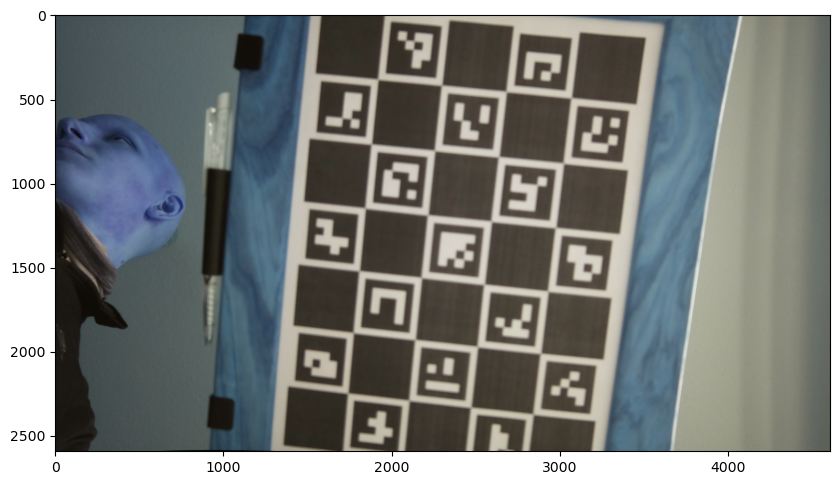

In [74]:
from matplotlib import pyplot as plt
img = cv2.imread(images["path"][15])

h, w = img.shape[:2]
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(cv2.undistort(img, camera_matrix, distortion_coefficients0))
plt.show()